# Gesture Recognition

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. Let's have professor Raghavan introduce you to the problem statement:

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie

# Importing required libraries

In [34]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import datetime
import os
import cv2
from cv2 import imread, resize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
# Checking GCE instance
!hostname

tensorflow-2-6-20220111-012814


In [4]:
# Checking available Nvidia GPU
!nvidia-smi

Wed Jan 12 11:04:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    62W / 149W |      0MiB / 11441MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

# Preparing data

## Getting dataset

In [6]:
# Unzip files
from zipfile import ZipFile

with ZipFile('data/new_data.zip', 'r') as zipobj:
    zipobj.extractall('data/')
    print('Files are unzipped') 

Files are unzipped


In [19]:
train_doc= np.random.permutation(open('data/Project_data/train.csv').readlines())
val_doc= np.random.permutation(open('data/Project_data/val.csv').readlines())
batch_size= 128 # Choosing batch size

## EDA

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


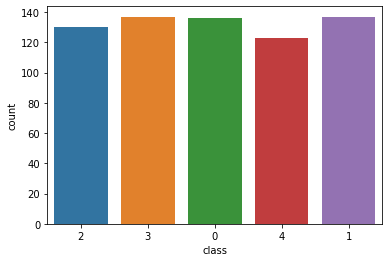

In [36]:
labels= list(map(lambda x: x.split(';')[-1].replace('\n',''), train_doc))
sns.countplot(labels)
plt.xlabel('class')
plt.show()

We have almost similar number of observations fo each class.

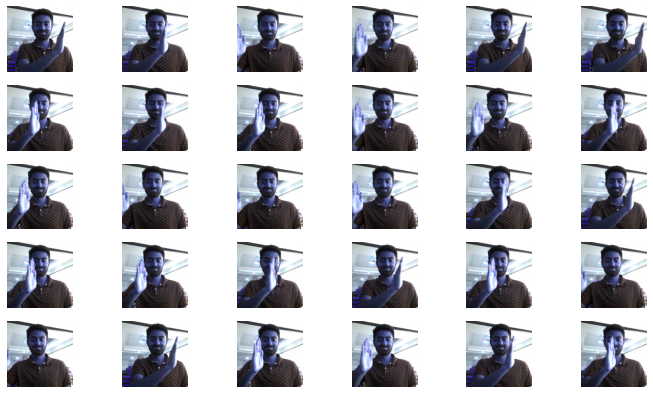

In [72]:
# Checking a random datapoint
data_idx= 99
path= 'data'+'/Project_data/train/'+train_doc[data_idx].replace('\n','').split(';')[0]
imagelist= []
for item in os.listdir(path):
    imagelist.append(path+'/'+item)

plt.figure(figsize= (12, 7))
for i, image in enumerate(imagelist):
    ax= plt.subplot(5, 6, i + 1)
    plt.axis('off')
    plt.imshow(cv2.imread(image))

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
# Defining no. of image sequences for each datapoint, height and width of each image
x= 30
y= 100
z= 100

In [7]:
def generator(source_path, folder_list, batch_size, labels= 5):
    print('Source path :',source_path, '; batch size :',batch_size)
    img_idx = list(range(0, 30)) #create a list of image numbers want to use for a particular video
    while True:
        t= np.random.permutation(folder_list)
        num_batches= len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data= np.zeros((batch_size,x,y,z,3)) 
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels= np.zeros((batch_size, labels)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs= os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx, item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them
                    #image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image= cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image= cv2.resize(image, (y, z))
                    # normalizing each channel (min-max scaling)
                    batch_data[folder,idx,:,:,0]= (image[:,:,0] - np.min(image[:,:,0])) / (np.max(image[:,:,0]) - np.min(image[:,:,0]))
                    batch_data[folder,idx,:,:,1]= (image[:,:,1] - np.min(image[:,:,1])) / (np.max(image[:,:,1]) - np.min(image[:,:,1]))
                    batch_data[folder,idx,:,:,2]= (image[:,:,2] - np.min(image[:,:,2])) / (np.max(image[:,:,2]) - np.min(image[:,:,2]))
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])]= 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        remaining_count= len(folder_list) - (batch_size * num_batches)
        if remaining_count > 0:
            #print('; remaining_count :',remaining_count)
            batch_data= np.zeros((remaining_count,x,y,z,3))
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels= np.zeros((remaining_count, labels))# batch_labels is the one hot representation of the output
            for folder in range(remaining_count): # iterate over the remaining_count
                imgs = os.listdir(source_path+'/'+ t[folder].split(';')[0]) # read all the images in the folder
                for idx, item in enumerate(img_idx): #  iterate over the frames/images of a folder to read them 
                    image= cv2.imread(source_path+'/'+ t[folder].strip().split(';')[0]+'/'+imgs[item])
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image= cv2.resize(image, (y, z))
                    # normalizing each channel (min-max scaling)                          
                    batch_data[folder,idx,:,:,0]= (image[:,:,0] - np.min(image[:,:,0])) / (np.max(image[:,:,0]) - np.min(image[:,:,0]))
                    batch_data[folder,idx,:,:,1]= (image[:,:,1] - np.min(image[:,:,1])) / (np.max(image[:,:,1]) - np.min(image[:,:,1]))
                    batch_data[folder,idx,:,:,2]= (image[:,:,2] - np.min(image[:,:,2])) / (np.max(image[:,:,2]) - np.min(image[:,:,2]))
                batch_labels[folder, int(t[folder].strip().split(';')[2])]= 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time= datetime.datetime.now()
train_path= 'data/Project_data/train'
val_path= 'data/Project_data/val'
num_train_sequences= len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences= len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs= 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


# Model building
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.
The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [9]:
import tensorflow as tf
import keras
from keras_visualizer import visualizer
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, Dense, GRU, LSTM, Flatten, GlobalMaxPool3D, TimeDistributed, Flatten, BatchNormalization, Dropout, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2
from keras.models import load_model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.resnet_v2 import ResNet50V2

In [10]:
def get_gen_steps(train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, batch_size):
    train_generator= generator(train_path, train_doc, batch_size)
    val_generator= generator(val_path, val_doc, batch_size)
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch= int(num_train_sequences/batch_size)
    else:
        steps_per_epoch= (num_train_sequences//batch_size) + 1
    if (num_val_sequences%batch_size) == 0:
        validation_steps= int(num_val_sequences/batch_size)
    else:
        validation_steps= (num_val_sequences//batch_size) + 1
        
    return train_generator, val_generator, steps_per_epoch, validation_steps

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath= 'model/'+ model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint= ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR= ReduceLROnPlateau(monitor= 'val_loss', factor= 0.1, patience= 10, verbose= 1)
callbacks_list= [checkpoint, LR]

----


## Approach 1: Conv2D + RNN

### Model 1: InceptionV3 (Finetuning) + LSTM

In [22]:
# Model function
def inceptionv3_lstm(train_layers_after, seq_shape, lstm_cells, hidden_units, dropout_rate, labels):
    inceptionv3= InceptionV3(weights= 'imagenet', include_top= False)
    for layer in inceptionv3.layers[:train_layers_after]:
        layer.trainable= False
    inputs= Input(shape= seq_shape)
    encoded_seq= TimeDistributed(inceptionv3)(inputs)
    flatten_layer= TimeDistributed(Flatten())(encoded_seq)
    encoded_datapoint= LSTM(lstm_cells)(flatten_layer)
    dense_layer= Dense(hidden_units, activation= 'relu')(encoded_datapoint)
    dropout_layer= Dropout(dropout_rate)(dense_layer)
    outputs= Dense(labels, activation='softmax')(dropout_layer)
    model= Model(inputs, outputs)
    model.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['categorical_accuracy'])
    return model

In [23]:
# Creating model
train_layers_after= 249
inp_shape= (100,100,3)
seq_shape= (30,100,100,3)
lstm_cells= 256
hidden_units= 512
dropout_rate= .5
labels= 5
incv3_lstm1= inceptionv3_lstm(train_layers_after, seq_shape, lstm_cells, hidden_units, dropout_rate, labels)
incv3_lstm1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30, 100, 100, 3)] 0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1, 1, 2048)    21802784  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 2048)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               2360320   
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 2565  

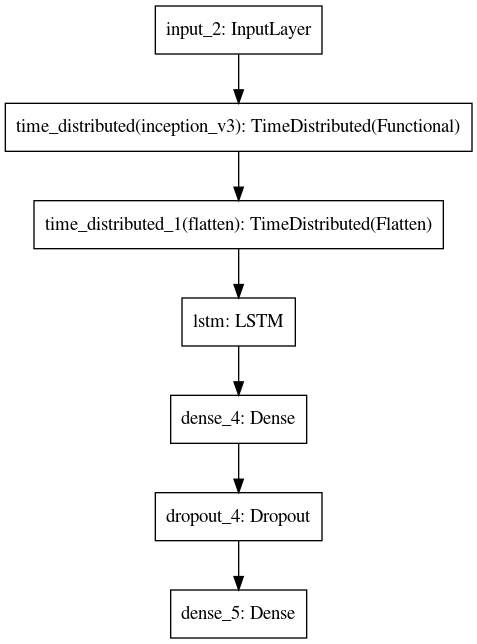

In [40]:
# Model architecture
plot_model(incv3_lstm1)

Lets now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [67]:
batch_size= 128

train_generator, val_generator, steps_per_epoch, validation_steps= get_gen_steps(train_path, train_doc, val_path, val_doc, 
                                                                                 num_train_sequences, num_val_sequences, batch_size)

history= incv3_lstm1.fit_generator(train_generator, steps_per_epoch= steps_per_epoch, epochs= 75, verbose= 1, 
                    callbacks= callbacks_list, validation_data=val_generator, 
                    validation_steps= validation_steps, class_weight= None, workers= 1, initial_epoch= 0)

Source path : data/Project_data/train ; batch size : 128
Epoch 1/75
6/6 [==============================] - ETA: 0s - loss: 1.5346 - categorical_accuracy: 0.3152 Source path : data/Project_data/val ; batch size : 128
; remaining_count : 100
; remaining_count : 100
6/6 [==============================] - 95s 16s/step - loss: 1.5346 - categorical_accuracy: 0.3152 - val_loss: 1.4258 - val_categorical_accuracy: 0.3900

Epoch 00001: saving model to model/model_init_2022-01-1102_03_44.398270/model-00001-1.53456-0.31523-1.42585-0.39000.h5
Epoch 2/75
6/6 [==============================] - ETA: 0s - loss: 0.8350 - categorical_accuracy: 0.7647 ; remaining_count : 100
; remaining_count : 100
6/6 [==============================] - 186s 36s/step - loss: 0.8350 - categorical_accuracy: 0.7647 - val_loss: 1.1641 - val_categorical_accuracy: 0.5400

Epoch 00002: saving model to model/model_init_2022-01-1102_03_44.398270/model-00002-0.83500-0.76471-1.16414-0.54000.h5
Epoch 3/75
6/6 [=======================

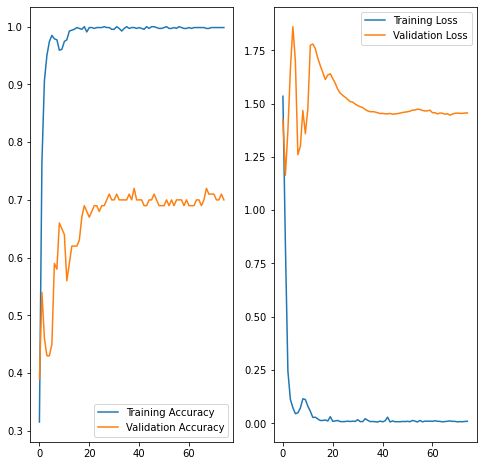

In [68]:
epochs= 75
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')


- Total params: 24,297,253  
- Trainable params: 13,609,349
- Non-trainable params: 10,687,904
- **Best Epoch:** 39
- **Training:   loss= 0.006, categorical_accuracy= 0.9985**
- **Validation: loss= 1.457,     categorical_accuracy= 0.72**

We have got best model in epoch 39 (model-00039-0.00603-0.99849-1.45704-0.72000.h5). This model is showing sign of overfitting.

### Model 2: InceptionV3 (Finetuning) + GRU

In [41]:
# Model function
def inceptionv3_gru1(train_layers_after, seq_shape, gru_cells, hidden_units, dropout_rate, labels):
    inceptionv3= InceptionV3(weights= 'imagenet', include_top= False)
    for layer in inceptionv3.layers[:train_layers_after]:
        layer.trainable= False
    inputs= Input(shape= seq_shape)
    encoded_seq= TimeDistributed(inceptionv3)(inputs)
    flatten_layer= TimeDistributed(Flatten())(encoded_seq)
    encoded_datapoint= GRU(gru_cells)(flatten_layer)
    dropout_layer1= Dropout(dropout_rate)(encoded_datapoint)
    dense_layer= Dense(hidden_units, activation= 'relu', kernel_initializer= 'he_normal')(dropout_layer1)
    dropout_layer2= Dropout(dropout_rate)(dense_layer)
    outputs= Dense(labels, activation= 'softmax')(dropout_layer2)
    model= Model(inputs, outputs)
    model.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['categorical_accuracy'])
    return model

In [42]:
# Building model
train_layers_after= 249
inp_shape= (100,100,3)
seq_shape= (30,100,100,3)
gru_cells= 256
hidden_units= 512
dropout_rate= .3
labels= 5
incv3_gru1= inceptionv3_gru1(train_layers_after, seq_shape, gru_cells, hidden_units, dropout_rate, labels)
incv3_gru1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 30, 100, 100, 3)] 0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 1, 1, 2048)    21802784  
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 2048)          0         
_________________________________________________________________
gru (GRU)                    (None, 256)               1771008   
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0   

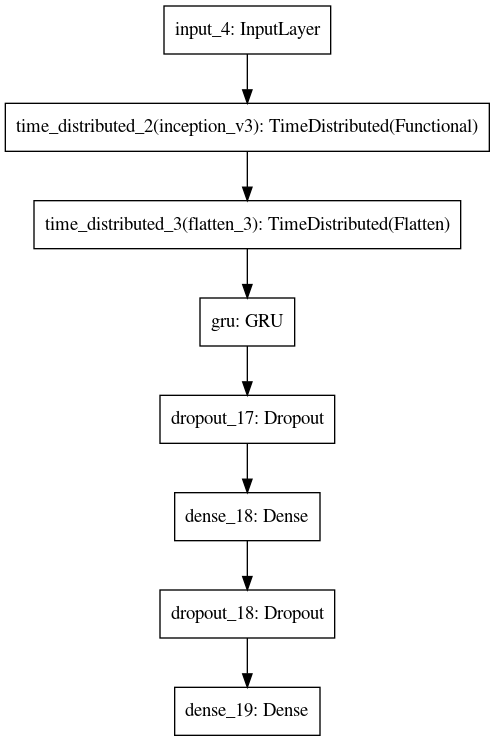

In [44]:
# Model architecture
plot_model(incv3_gru1)

In [18]:
# Adding early stopping
ES= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 15, mode= 'min', verbose= 1)
callbacks_list = [checkpoint, LR, ES]

In [ ]:
# Model architecture
plot_model(incv3_lstm1)

In [19]:
batch_size= 128
train_generator, val_generator, steps_per_epoch, validation_steps= get_gen_steps(train_path, train_doc, val_path, val_doc, 
                                                                                 num_train_sequences, num_val_sequences, batch_size)

history= incv3_gru1.fit_generator(train_generator, steps_per_epoch= steps_per_epoch, epochs= 40, verbose=1, 
                    callbacks= callbacks_list, validation_data=val_generator, 
                    validation_steps= validation_steps, class_weight= None, workers= 1, initial_epoch= 0)

Source path : data/Project_data/train ; batch size : 128
Epoch 1/40
6/6 [==============================] - ETA: 0s - loss: 0.8295 - categorical_accuracy: 0.6998Source path : data/Project_data/val ; batch size : 128
; remaining_count : 100
; remaining_count : 100
6/6 [==============================] - 113s 21s/step - loss: 0.8295 - categorical_accuracy: 0.6998 - val_loss: 1.6798 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model/model_init_2022-01-1108_41_12.901620/model-00001-0.82950-0.69985-1.67985-0.29000.h5
Epoch 2/40
6/6 [==============================] - ETA: 0s - loss: 0.2756 - categorical_accuracy: 0.9246; remaining_count : 100
; remaining_count : 100
6/6 [==============================] - 58s 10s/step - loss: 0.2756 - categorical_accuracy: 0.9246 - val_loss: 1.4762 - val_categorical_accuracy: 0.4600

Epoch 00002: saving model to model/model_init_2022-01-1108_41_12.901620/model-00002-0.27565-0.92459-1.47622-0.46000.h5
Epoch 3/40
6/6 [=========================

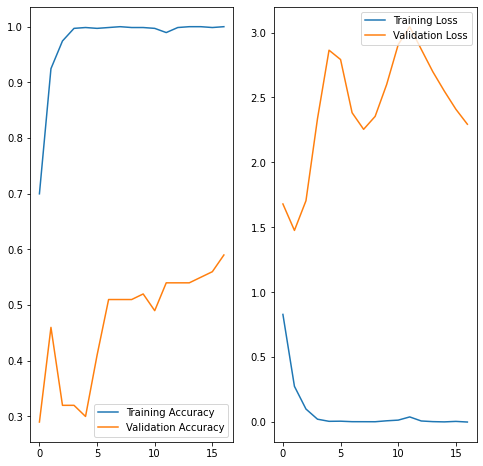

In [20]:
epochs= 17
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

- Total params: 23,707,941
- Trainable params: 13,020,037
- Non-trainable params: 10,687,904
- **Best Epoch:** 17
- **Training:   loss= 8.4316e-04, categorical_accuracy= 1.00**
- **Validation: loss= 2.2937,     categorical_accuracy= 0.59**

We have got best model in epoch 17 (model-00017-0.00084-1.00000-2.29372-0.59000.h5). This model is showing sign of overfitting.

### Model 3: InceptionV3 (Finetuning) + GRU  with higher Dropout rate and L2 Regularization

In [45]:
# Model function
def inceptionv3_gru2(train_layers_after, seq_shape, gru_cells, hidden_units, dropout_rate, labels):
    inceptionv3= InceptionV3(weights= 'imagenet', include_top= False)
    for layer in inceptionv3.layers[:train_layers_after]:
        layer.trainable= False
    inputs= Input(shape= seq_shape)
    encoded_seq= TimeDistributed(inceptionv3)(inputs)
    flatten_layer= TimeDistributed(Flatten())(encoded_seq)
    encoded_datapoint= GRU(gru_cells)(flatten_layer)
    dropout_layer1= Dropout(dropout_rate)(encoded_datapoint)
    dense_layer= Dense(hidden_units, activation= 'relu', kernel_initializer= 'he_normal', kernel_regularizer= 'l2', activity_regularizer= keras.regularizers.l2(1e-5))(dropout_layer1)
    dropout_layer2= Dropout(dropout_rate)(dense_layer)
    outputs= Dense(labels, activation= 'softmax')(dropout_layer2)
    model= Model(inputs, outputs)
    model.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['categorical_accuracy'])
    return model

In [46]:
# Building model
train_layers_after= 249
inp_shape= (100,100,3)
seq_shape= (30,100,100,3)
gru_cells= 256
hidden_units= 512
dropout_rate= .5
labels= 5
incv3_gru2= inceptionv3_gru2(train_layers_after, seq_shape, gru_cells, hidden_units, dropout_rate, labels)
incv3_gru2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 30, 100, 100, 3)] 0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 1, 1, 2048)    21802784  
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 2048)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               1771008   
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0   

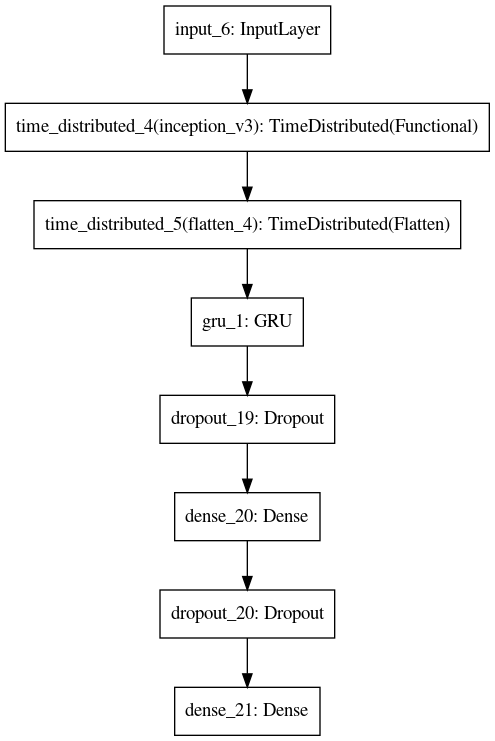

In [47]:
# Model architecture
plot_model(incv3_gru2)

In [43]:
# Adding early stopping
ES= tf.keras.callbacks.EarlyStopping(monitor= 'val_loss', patience= 15, mode= 'min', verbose= 1)
callbacks_list= [checkpoint, LR, ES]

In [44]:
history= incv3_gru2.fit_generator(train_generator, steps_per_epoch= steps_per_epoch, epochs= 30, verbose=1, 
                    callbacks= callbacks_list, validation_data=val_generator, 
                    validation_steps= validation_steps, class_weight= None, workers= 1, initial_epoch= 0)

Source path : data/Project_data/train ; batch size : 128


2022-01-11 02:04:50.461139: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 460800000 exceeds 10% of free system memory.
2022-01-11 02:04:50.886606: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-01-11 02:04:58.975186: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 460800000 exceeds 10% of free system memory.
2022-01-11 02:05:00.067784: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-01-11 02:05:06.995765: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 460800000 exceeds 10% of free system memory.


2/6 [=========>....................] - ETA: 27s - loss: 12.2222 - categorical_accuracy: 0.2266 

2022-01-11 02:05:59.291181: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 460800000 exceeds 10% of free system memory.


3/6 [==============>...............] - ETA: 25s - loss: 12.1226 - categorical_accuracy: 0.2292

2022-01-11 02:06:09.023832: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 460800000 exceeds 10% of free system memory.


6/6 [==============================] - ETA: 0s - loss: 11.8797 - categorical_accuracy: 0.2790Source path : data/Project_data/val ; batch size : 128
; remaining_count : 100
; remaining_count : 100
6/6 [==============================] - 143s 17s/step - loss: 11.8797 - categorical_accuracy: 0.2790 - val_loss: 11.5035 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model/model_init_2022-01-1102_03_44.398270/model-00001-11.87974-0.27903-11.50353-0.29000.h5
Epoch 2/30
6/6 [==============================] - ETA: 0s - loss: 10.6366 - categorical_accuracy: 0.5445; remaining_count : 100
; remaining_count : 100
6/6 [==============================] - 61s 11s/step - loss: 10.6366 - categorical_accuracy: 0.5445 - val_loss: 11.0763 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model/model_init_2022-01-1102_03_44.398270/model-00002-10.63665-0.54449-11.07635-0.21000.h5
Epoch 3/30
6/6 [==============================] - ETA: 0s - loss: 9.6100 - categorical_accuracy: 0.

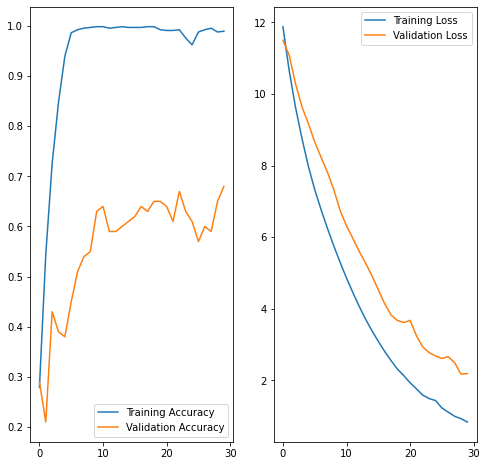

In [46]:
epochs= 30
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')

In [21]:
model= load_model('model/model_init_2022-01-1102_03_44.398270/model-00030-0.83397-0.98944-2.18697-0.68000.h5')

callbacks_list= [checkpoint, LR]

history= model.fit_generator(train_generator, steps_per_epoch= steps_per_epoch, epochs= 30, verbose= 1, 
                    callbacks= callbacks_list, validation_data= val_generator, 
                    validation_steps= validation_steps, class_weight= None, workers= 1)

Epoch 1/30
6/6 [==============================] - ETA: 0s - loss: 0.7476 - categorical_accuracy: 0.9940; remaining_count : 100
; remaining_count : 100
6/6 [==============================] - 74s 12s/step - loss: 0.7476 - categorical_accuracy: 0.9940 - val_loss: 2.2162 - val_categorical_accuracy: 0.6600

Epoch 00001: saving model to model/model_init_2022-01-1108_41_12.901620/model-00001-0.74760-0.99397-2.21622-0.66000.h5
Epoch 2/30
6/6 [==============================] - ETA: 0s - loss: 0.6666 - categorical_accuracy: 0.9985; remaining_count : 100
; remaining_count : 100
6/6 [==============================] - 64s 11s/step - loss: 0.6666 - categorical_accuracy: 0.9985 - val_loss: 2.2514 - val_categorical_accuracy: 0.6300

Epoch 00002: saving model to model/model_init_2022-01-1108_41_12.901620/model-00002-0.66657-0.99849-2.25142-0.63000.h5
Epoch 3/30
6/6 [==============================] - ETA: 0s - loss: 0.6159 - categorical_accuracy: 0.9955; remaining_count : 100
; remaining_count : 100
6/6

- Total params: 23,707,941
- Trainable params: 13,020,037
- Non-trainable params: 10,687,904
- **Best Epoch:** 30 of first run
- **Training:   loss= 0.8340, categorical_accuracy= 0.9894**
- **Validation: loss= 2.1870,     categorical_accuracy= 0.6800**

We have got best model in epoch 30 of first run (model-00030-0.83397-0.98944-2.18697-0.68000.h5). This model is showing sign of overfitting.

In [ ]:
# Model function
def resnet50v2_lstm(train_layers_after, seq_shape, lstm_cells, hidden_units, dropout_rate, labels):
    resnet2_gru= ResNet50V2(weights= 'imagenet', include_top= False)
    for layer in resnet2_gru.layers[:train_layers_after]:
        layer.trainable= False
    inputs= Input(shape= seq_shape)
    encoded_seq= TimeDistributed(resnet2_gru)(inputs)
    flatten_layer= TimeDistributed(Flatten())(encoded_seq)
    encoded_datapoint= LSTM(lstm_cells)(flatten_layer)
    dropout_layer1= Dropout(dropout_rate)(encoded_datapoint)
    dense_layer= Dense(hidden_units, activation= 'relu', kernel_initializer= 'he_normal', kernel_regularizer= 'l2')(dropout_layer1)
    dropout_layer2= Dropout(dropout_rate)(dense_layer)
    outputs= Dense(labels, activation= 'softmax')(dropout_layer2)
    model= Model(inputs, outputs)
    model.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['categorical_accuracy'])
    return model

### Model 4: ResNet50V2 (Finetuning) + GRU  with Dropout and L2 Regularization

In [49]:
# Model function
def resnet50v2_gru(train_layers_after, seq_shape, gru_cells, hidden_units, dropout_rate, labels):
    resnet2_gru= ResNet50V2(weights= 'imagenet', include_top= False)
    for layer in resnet2_gru.layers[:train_layers_after]:
        layer.trainable= False
    inputs= Input(shape= seq_shape)
    encoded_seq= TimeDistributed(resnet2_gru)(inputs)
    flatten_layer= TimeDistributed(Flatten())(encoded_seq)
    encoded_datapoint= GRU(gru_cells)(flatten_layer)
    dropout_layer1= Dropout(dropout_rate)(encoded_datapoint)
    dense_layer= Dense(hidden_units, activation= 'relu', kernel_initializer= 'he_normal', kernel_regularizer= 'l2')(dropout_layer1)
    dropout_layer2= Dropout(dropout_rate)(dense_layer)
    outputs= Dense(labels, activation= 'softmax')(dropout_layer2)
    model= Model(inputs, outputs)
    model.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['categorical_accuracy'])
    return model

In [50]:
# Building model
train_layers_after= 154
inp_shape= (100,100,3)
seq_shape= (30,100,100,3)
gru_cells= 128
hidden_units= 512
dropout_rate= .3
labels= 5
resnet_gru= resnet50v2_gru(train_layers_after, seq_shape, gru_cells, hidden_units, dropout_rate, labels)
resnet_gru.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 30, 100, 100, 3)] 0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 4, 4, 2048)    23564800  
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 32768)         0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               12632832  
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_22 (Dropout)         (None, 512)               0   

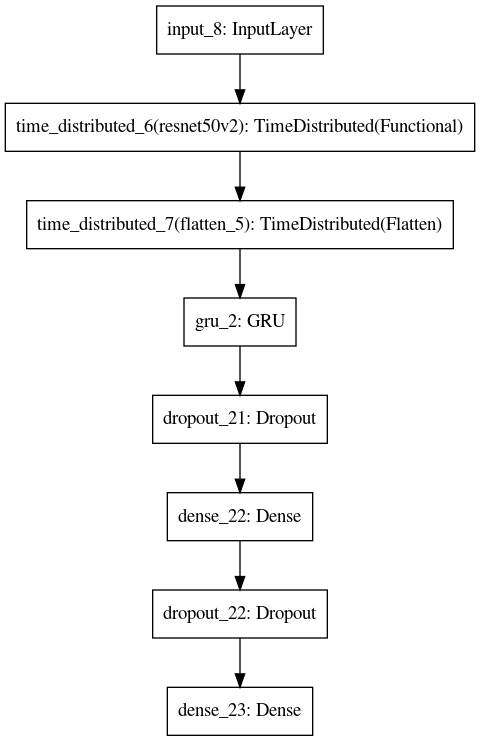

In [51]:
# Model architecture
plot_model(resnet_gru)

In [54]:
batch_size= 64
train_generator, val_generator, steps_per_epoch, validation_steps= get_gen_steps(train_path, train_doc, val_path, val_doc, 
                                                                                 num_train_sequences, num_val_sequences, batch_size)

history= resnet_gru.fit_generator(train_generator, steps_per_epoch= steps_per_epoch, epochs= 50, verbose=1, 
                    callbacks= callbacks_list, validation_data=val_generator, 
                    validation_steps= validation_steps, class_weight= None, workers= 1, initial_epoch= 0)

Source path : data/Project_data/train ; batch size : 64
Epoch 1/50
11/11 [==============================] - 195s 16s/step - loss: 11.8620 - categorical_accuracy: 0.3002 - val_loss: 10.9708 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model/model_init_2022-01-1111_24_51.444482/model-00001-11.86197-0.30015-10.97079-0.46000.h5
Epoch 2/50
11/11 [==============================] - 180s 17s/step - loss: 10.2697 - categorical_accuracy: 0.5988 - val_loss: 10.4847 - val_categorical_accuracy: 0.3800

Epoch 00002: saving model to model/model_init_2022-01-1111_24_51.444482/model-00002-10.26969-0.59879-10.48473-0.38000.h5
Epoch 3/50
11/11 [==============================] - 170s 16s/step - loss: 9.1298 - categorical_accuracy: 0.7813 - val_loss: 10.0576 - val_categorical_accuracy: 0.4500

Epoch 00003: saving model to model/model_init_2022-01-1111_24_51.444482/model-00003-9.12978-0.78130-10.05759-0.45000.h5
Epoch 4/50
11/11 [==============================] - 169s 16s/step - loss: 8.

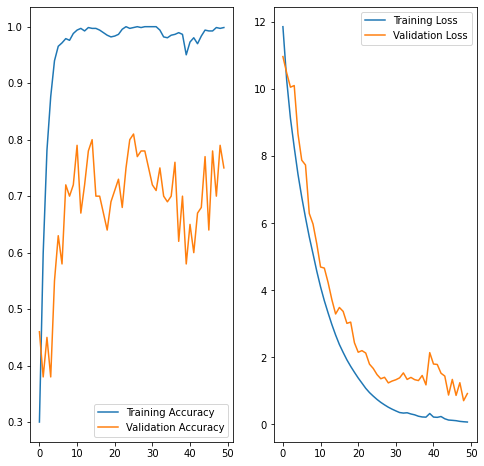

In [56]:
epochs= 50
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

- Total params: 36,266,245
- Trainable params: 27,672,325
- Non-trainable params: 8,593,920
- **Best Epoch:** 26
- **Training:   loss: 0.7449, categorical_accuracy: 0.9985**
- **Validation: val_loss: 1.4857, val_categorical_accuracy: 0.8100**

We have got best model in epoch 26 of second run (model-00026-0.74487-0.99849-1.48567-0.81000.h5).

### Model 5: Xception (Finetuning) + LSTM  with Dropout and L2 Regularization

In [52]:
# Model function
def xception_lstm(train_layers_after, seq_shape, lstm_cells, hidden_units, dropout_rate, labels):
    xcp= Xception(weights= 'imagenet', include_top= False)
    for layer in xcp.layers[:train_layers_after]:
        layer.trainable= False
    inputs= Input(shape= seq_shape)
    encoded_seq= TimeDistributed(xcp)(inputs)
    flatten_layer= TimeDistributed(Flatten())(encoded_seq)
    encoded_datapoint= LSTM(lstm_cells)(flatten_layer)
    dropout_layer1= Dropout(dropout_rate)(encoded_datapoint)
    dense_layer= Dense(hidden_units, activation= 'relu', kernel_initializer= 'he_normal', kernel_regularizer= 'l2')(dropout_layer1)
    dropout_layer2= Dropout(dropout_rate)(dense_layer)
    outputs= Dense(labels, activation= 'softmax')(dropout_layer2)
    model= Model(inputs, outputs)
    model.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['categorical_accuracy'])
    return model

In [53]:
# Checking callbacks
print(callbacks_list)

[<keras.callbacks.ModelCheckpoint object at 0x7f7b8aff3990>, <keras.callbacks.ReduceLROnPlateau object at 0x7f7b42120e90>]


In [54]:
# Creating model
train_layers_after= 114
inp_shape= (100,100,3)
seq_shape= (30,100,100,3)
lstm_cells= 256
hidden_units= 512
dropout_rate= .25
labels= 5
xcp_lstm= xception_lstm(train_layers_after, seq_shape, lstm_cells, hidden_units, dropout_rate, labels)
xcp_lstm.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 30, 100, 100, 3)] 0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 30, 3, 3, 2048)    20861480  
_________________________________________________________________
time_distributed_9 (TimeDist (None, 30, 18432)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               19137536  
_________________________________________________________________
dropout_23 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_24 (Dropout)         (None, 512)               0   

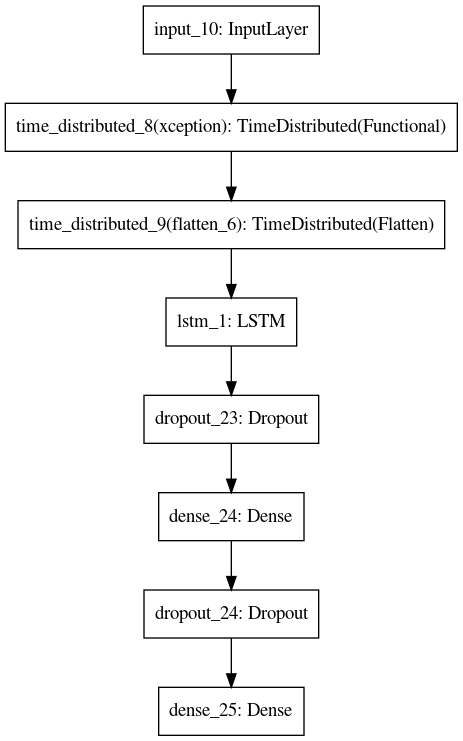

In [55]:
# Model architecture
plot_model(xcp_lstm)

In [18]:
# Reducing batch size to 32 because of out of memory issue
batch_size= 32
train_generator, val_generator, steps_per_epoch, validation_steps= get_gen_steps(train_path, train_doc, val_path, val_doc, 
                                                                                 num_train_sequences, num_val_sequences, batch_size)

history= xcp_lstm.fit_generator(train_generator, steps_per_epoch= steps_per_epoch, epochs= 30, verbose= 1, 
                    callbacks= callbacks_list, validation_data=val_generator, 
                    validation_steps= validation_steps, class_weight= None, workers= 1, initial_epoch= 0)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path : data/Project_data/train ; batch size : 32


2022-01-11 11:25:43.785965: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-01-11 11:25:49.541567: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


21/21 [==============================] - 153s 6s/step - loss: 10.8844 - categorical_accuracy: 0.2383 - val_loss: 9.4430 - val_categorical_accuracy: 0.4100

Epoch 00001: saving model to model/model_init_2022-01-1111_24_51.444482/model-00001-10.88441-0.23831-9.44305-0.41000.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
21/21 [==============================] - 106s 5s/step - loss: 8.2234 - categorical_accuracy: 0.5023 - val_loss: 6.9676 - val_categorical_accuracy: 0.6200

Epoch 00002: saving model to model/model_init_2022-01-1111_24_51.444482/model-00002-8.22340-0.50226-6.96756-0.62000.h5
Epoch 3/30
21/21 [==============================] - 106s 5s/step - loss: 6.0363 - categorical_accuracy: 0.7149 - val_loss: 5.3942 - val_categorical_accuracy: 0.6900

Epoch 00003: saving model to model/model_init_2022-01-1111_24_51.444482/model-00003-6.03630-0.71493-5.39424-0.69000.h5
Epoch 4/30
21/21 [==============================] - 104s 5s/step - loss: 4.5804 - categorical_accuracy: 0.8205 - val_loss: 4.4295 - val_categorical_accuracy: 0.7200

Epoch 00004: saving model to model/model_init_2022-01-1111_24_51.444482/model-00004-4.58042-0.82051-4.42946-0.72000.h5
Epoch 5/30
21/21 [==============================] - 106s 5s/step - loss: 3.4495 - categorical_accuracy: 0.8839 - val_loss: 3.5613 - val_categoric

----

- Total params: 40,133,165
- Trainable params: 26,061,525
- Non-trainable params: 14,071,640
- Best Epoch: 7
- **Training: loss: 2.0037 - categorical_accuracy: 0.9548**
- **Validation: val_loss: 2.2650 - val_categorical_accuracy: 0.8500**

We have got best model in epoch 7 (model-00007-2.00373-0.95475-2.26498-0.85000.h5).

## Approach 2: Conv3D

### Model 6: Conv3D with BatchNormalization, Dropout, Dense layers with he_normal initialization

In [56]:
# Model function
def conv3D_model(seq_shape, labels):
    model= Sequential()
    model.add(Conv3D(16, kernel_size= (3,3,3), input_shape= seq_shape, padding= 'same'))
    model.add(BatchNormalization(momentum= .9))
    model.add(Activation('relu'))
    model.add(Conv3D(16, kernel_size= (3,3,3), padding= 'same'))
    model.add(BatchNormalization(momentum= .9))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size= (2,2,2)))
    model.add(Conv3D(32, kernel_size= (3,3,3), padding= 'same'))
    model.add(BatchNormalization(momentum= .9))
    model.add(Activation('relu'))
    model.add(Conv3D(32, kernel_size= (3,3,3), padding= 'same'))
    model.add(BatchNormalization(momentum= .9))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size= (2,2,2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(256, activation= 'relu', kernel_initializer= 'he_normal'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation= 'relu', kernel_initializer= 'he_normal'))
    model.add(Dropout(0.3))
    model.add(Dense(labels, activation= 'softmax'))
    model.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['categorical_accuracy'])
    return model

In [57]:
# Building model
seq_shape= (30,100,100,3)
labels= 5
conv3D_m= conv3D_model(seq_shape, labels)
conv3D_m.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 30, 100, 100, 16)  1312      
_________________________________________________________________
batch_normalization_302 (Bat (None, 30, 100, 100, 16)  64        
_________________________________________________________________
activation_298 (Activation)  (None, 30, 100, 100, 16)  0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 30, 100, 100, 16)  6928      
_________________________________________________________________
batch_normalization_303 (Bat (None, 30, 100, 100, 16)  64        
_________________________________________________________________
activation_299 (Activation)  (None, 30, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 15, 50, 50, 16)   

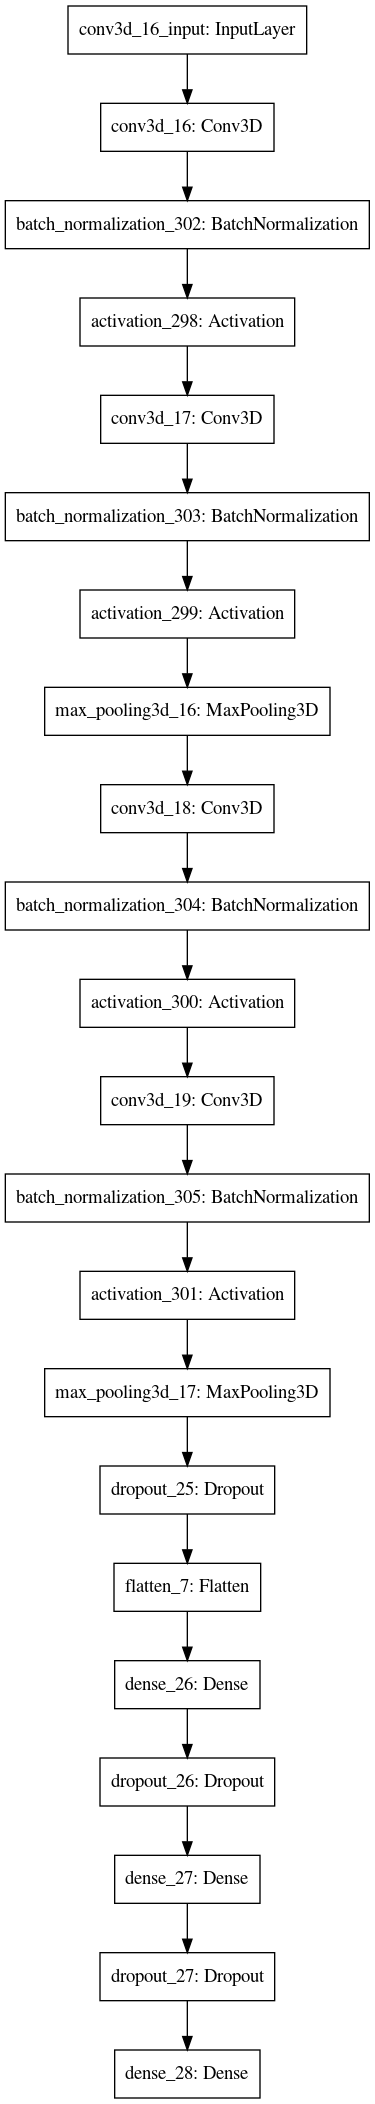

In [58]:
# Model architecture
plot_model(conv3D_m)

In [26]:
# Reducing batch size to 48 because of out of memory issue
batch_size= 48
train_generator, val_generator, steps_per_epoch, validation_steps= get_gen_steps(train_path, train_doc, val_path, val_doc, 
                                                                                 num_train_sequences, num_val_sequences, batch_size)

history= conv3D_m.fit_generator(train_generator, steps_per_epoch= steps_per_epoch, epochs= 30, verbose= 1, 
                    callbacks= callbacks_list, validation_data=val_generator, 
                    validation_steps= validation_steps, class_weight= None, workers= 1, initial_epoch= 0)

Source path : data/Project_data/train ; batch size : 48
Epoch 1/30
14/14 [==============================] - 65s 5s/step - loss: 58.3889 - categorical_accuracy: 0.2428 - val_loss: 9.5188 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model/model_init_2022-01-1111_24_51.444482/model-00001-58.38887-0.24284-9.51880-0.24000.h5
Epoch 2/30
14/14 [==============================] - 63s 5s/step - loss: 19.2866 - categorical_accuracy: 0.2896 - val_loss: 3.5365 - val_categorical_accuracy: 0.3100

Epoch 00002: saving model to model/model_init_2022-01-1111_24_51.444482/model-00002-19.28664-0.28959-3.53654-0.31000.h5
Epoch 3/30
14/14 [==============================] - 61s 4s/step - loss: 6.3758 - categorical_accuracy: 0.3017 - val_loss: 2.4098 - val_categorical_accuracy: 0.2500

Epoch 00003: saving model to model/model_init_2022-01-1111_24_51.444482/model-00003-6.37582-0.30166-2.40982-0.25000.h5
Epoch 4/30
14/14 [==============================] - 64s 5s/step - loss: 2.3517 - categor

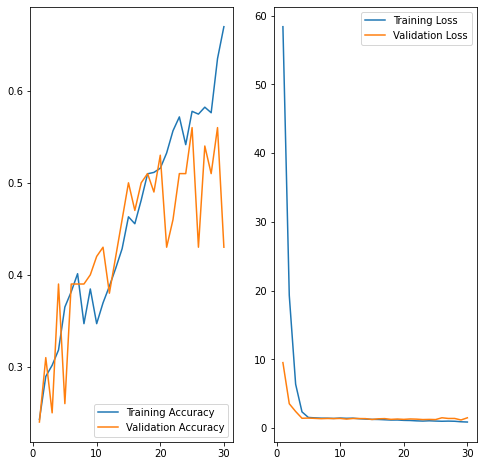

In [32]:
epochs= 30
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range= range(1, epochs+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [33]:
# Continuing training from previous saved model
model= load_model('model/model_init_2022-01-1111_24_51.444482/model-00030-0.87403-0.66968-1.49119-0.43000.h5')

callbacks_list= [checkpoint, LR]

history= model.fit_generator(train_generator, steps_per_epoch= steps_per_epoch, epochs= 30, verbose= 1, 
                    callbacks= callbacks_list, validation_data= val_generator, 
                    validation_steps= validation_steps, class_weight= None, workers= 1)

Epoch 1/30
14/14 [==============================] - 65s 5s/step - loss: 0.8722 - categorical_accuracy: 0.6772 - val_loss: 1.5056 - val_categorical_accuracy: 0.4900

Epoch 00001: saving model to model/model_init_2022-01-1111_24_51.444482/model-00001-0.87219-0.67722-1.50558-0.49000.h5
Epoch 2/30
14/14 [==============================] - 64s 5s/step - loss: 0.9756 - categorical_accuracy: 0.6018 - val_loss: 1.3837 - val_categorical_accuracy: 0.4600

Epoch 00002: saving model to model/model_init_2022-01-1111_24_51.444482/model-00002-0.97564-0.60181-1.38372-0.46000.h5
Epoch 3/30
14/14 [==============================] - 61s 4s/step - loss: 0.9170 - categorical_accuracy: 0.6184 - val_loss: 1.8632 - val_categorical_accuracy: 0.4400

Epoch 00003: saving model to model/model_init_2022-01-1111_24_51.444482/model-00003-0.91700-0.61840-1.86317-0.44000.h5
Epoch 4/30
14/14 [==============================] - 64s 5s/step - loss: 0.8291 - categorical_accuracy: 0.6953 - val_loss: 1.2346 - val_categorical_a

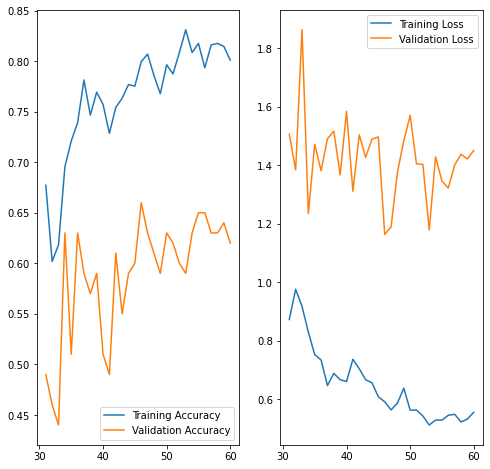

In [35]:
epochs= 30
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range= range(epochs+1, 2*epochs + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Continuing training from previous saved model
model= load_model('model/model_init_2022-01-1111_24_51.444482/model-00030-0.55498-0.80090-1.44986-0.62000.h5')

callbacks_list= [checkpoint, LR]

history= model.fit_generator(train_generator, steps_per_epoch= steps_per_epoch, epochs= 30, verbose= 1, 
                    callbacks= callbacks_list, validation_data= val_generator, 
                    validation_steps= validation_steps, class_weight= None, workers= 1)

- Total params: 35,923,957
- Trainable params: 35,923,765
- Non-trainable params: 192
- **Best Epoch:** 16
- **Training: 0.5909 - categorical_accuracy: 0.7994**
- **Validation:  val_loss: 1.1632, val_categorical_accuracy: 0.6600**

We have got best model in epoch 16 of second run (model-00016-0.59093-0.79940-1.16324-0.66000.h5).
Even after 60 epochs model performance is not that good. It failed to completely overfit. Next we'll build bit complex Conv3D model.

### Model 7: Conv3D with higher Dropout and Dense layers (reduced params)

In [1]:
# Model function
def conv3D_model1(seq_shape, labels):
    model= Sequential()
    model.add(Conv3D(16, kernel_size= (3,3,3), input_shape= seq_shape, padding= 'same'))
    model.add(BatchNormalization(momentum= .9))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size= (2,2,2)))
    model.add(Conv3D(32, kernel_size= (3,3,3), padding= 'same'))
    model.add(BatchNormalization(momentum= .9))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size= (2,2,2)))
    model.add(Conv3D(64, kernel_size= (3,3,3), padding= 'same'))
    model.add(BatchNormalization(momentum= .9))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size= (2,2,2)))
    model.add(Conv3D(128, kernel_size= (3,3,3), padding= 'same'))
    model.add(BatchNormalization(momentum= .9))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size= (2,2,2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(512, activation= 'relu', kernel_initializer= 'he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation= 'relu', kernel_initializer= 'he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation= 'relu', kernel_initializer= 'he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(labels, activation= 'softmax'))
    model.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['categorical_accuracy'])
    return model

In [60]:
# Building model
seq_shape= (30,100,100,3)
labels= 5
conv3D_m1= conv3D_model1(seq_shape, labels)
conv3D_m1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 30, 100, 100, 16)  1312      
_________________________________________________________________
batch_normalization_306 (Bat (None, 30, 100, 100, 16)  64        
_________________________________________________________________
activation_302 (Activation)  (None, 30, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 15, 50, 50, 32)    13856     
_________________________________________________________________
batch_normalization_307 (Bat (None, 15, 50, 50, 32)    128       
_________________________________________________________________
activation_303 (Activation)  (None, 15, 50, 50, 32)   

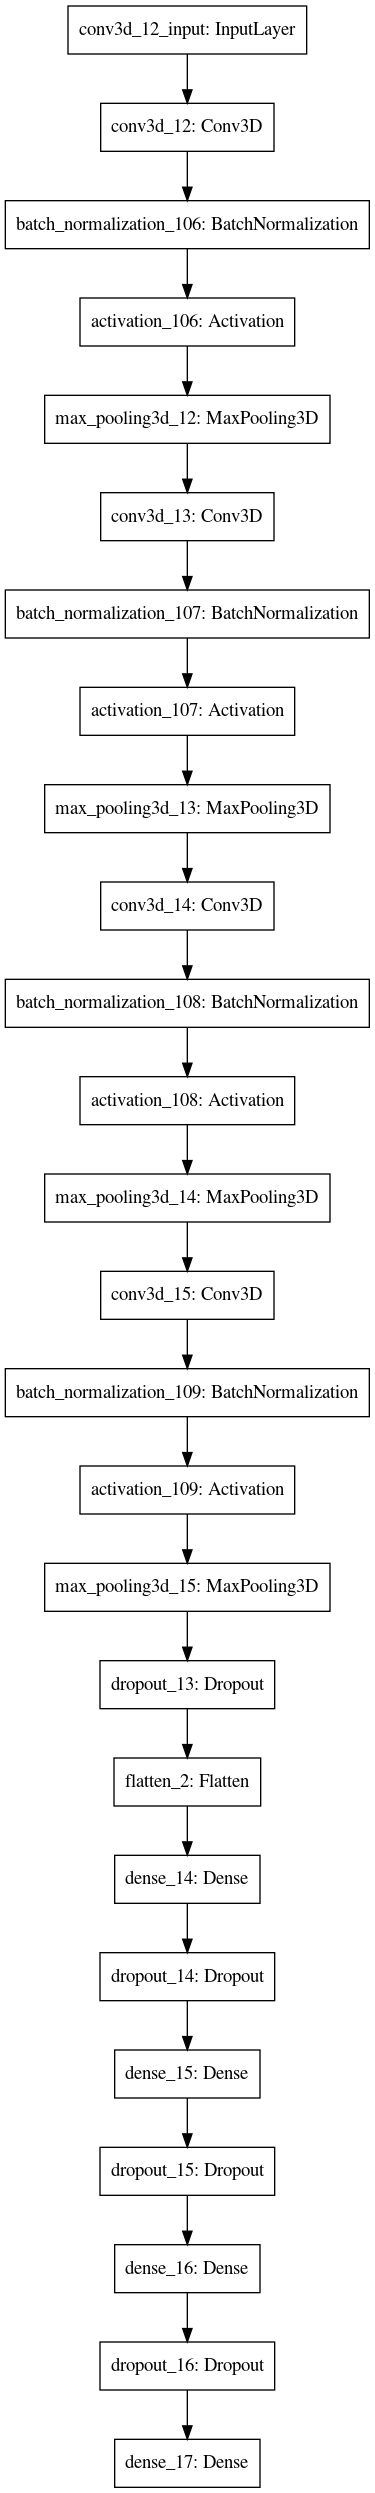

In [39]:
# Model architecture
plot_model(conv3D_m1)

In [54]:
# Reducing batch size to 64 because of out of memory issue
batch_size= 64
train_generator, val_generator, steps_per_epoch, validation_steps= get_gen_steps(train_path, train_doc, val_path, val_doc, 
                                                                                 num_train_sequences, num_val_sequences, batch_size)

history= conv3D_m1.fit_generator(train_generator, steps_per_epoch= steps_per_epoch, epochs= 30, verbose=1, 
                    callbacks= callbacks_list, validation_data=val_generator, 
                    validation_steps= validation_steps, class_weight= None, workers= 1, initial_epoch= 0)

Source path : data/Project_data/train ; batch size : 64
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 6.1076 - categorical_accuracy: 0.2202Source path : data/Project_data/val ; batch size : 64
; remaining_count : 36
11/11 [==============================] - 82s 8s/step - loss: 6.1076 - categorical_accuracy: 0.2202 - val_loss: 1.5064 - val_categorical_accuracy: 0.3900

Epoch 00001: saving model to model/model_init_2022-01-1102_03_44.398270/model-00001-6.10758-0.22021-1.50635-0.39000.h5
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 2.4411 - categorical_accuracy: 0.2413; remaining_count : 36
; remaining_count : 36
11/11 [==============================] - 59s 6s/step - loss: 2.4411 - categorical_accuracy: 0.2413 - val_loss: 1.5983 - val_categorical_accuracy: 0.2900

Epoch 00002: saving model to model/model_init_2022-01-1102_03_44.398270/model-00002-2.44107-0.24133-1.59827-0.29000.h5
Epoch 3/30
11/11 [==============================] - 63s 6s/step -

We can see that model performance is still improving. Let's load the final model and keep training it for 30 more epochs.

In [59]:
model= load_model('model/model_init_2022-01-1102_03_44.398270/model-00030-0.86130-0.63198-0.93258-0.67000.h5')

history= model.fit_generator(train_generator, steps_per_epoch= steps_per_epoch, epochs= 30, verbose=1, 
                    callbacks= callbacks_list, validation_data= val_generator, 
                    validation_steps= validation_steps, class_weight= None, workers= 1)

Epoch 1/30
11/11 [==============================] - 62s 6s/step - loss: 0.7720 - categorical_accuracy: 0.6606 - val_loss: 1.2088 - val_categorical_accuracy: 0.4900

Epoch 00001: saving model to model/model_init_2022-01-1102_03_44.398270/model-00001-0.77202-0.66063-1.20879-0.49000.h5
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.8220 - categorical_accuracy: 0.6697; remaining_count : 36
; remaining_count : 36
11/11 [==============================] - 75s 7s/step - loss: 0.8220 - categorical_accuracy: 0.6697 - val_loss: 0.9713 - val_categorical_accuracy: 0.5800

Epoch 00002: saving model to model/model_init_2022-01-1102_03_44.398270/model-00002-0.82198-0.66968-0.97126-0.58000.h5
Epoch 3/30
11/11 [==============================] - 60s 6s/step - loss: 0.7344 - categorical_accuracy: 0.7179 - val_loss: 0.9383 - val_categorical_accuracy: 0.5500

Epoch 00003: saving model to model/model_init_2022-01-1102_03_44.398270/model-00003-0.73440-0.71795-0.93834-0.55000.h5
Epoch 4/

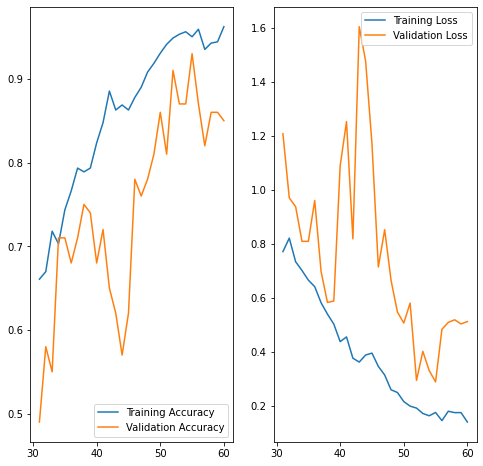

In [60]:
epochs= 30
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range= range(epochs+1, 2*epochs + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')

- Total params: 2,817,477  
- Trainable params: 2,816,997
- Non-trainable params: 480
- **Best Epoch:** 25 of second run (55th Epoch)
- **Training:   loss: 0.1759 - categorical_accuracy: 0.9502**
- **Validation: val_loss: 0.2894 - val_categorical_accuracy: 0.930**

We have got best model in epoch 25 of second run (model-00025-0.17594-0.95023-0.28937-0.93000.h5).

### Model 8: Conv3D (Model 7 with Nadam as optimizer)

In [2]:
# Model function
def conv3D_model2(seq_shape, labels):
    model= Sequential()
    model.add(Conv3D(16, kernel_size= (3,3,3), input_shape= seq_shape, padding= 'same'))
    model.add(BatchNormalization(momentum= .9))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size= (2,2,2)))
    model.add(Conv3D(32, kernel_size= (3,3,3), padding= 'same'))
    model.add(BatchNormalization(momentum= .9))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size= (2,2,2)))
    model.add(Conv3D(64, kernel_size= (3,3,3), padding= 'same'))
    model.add(BatchNormalization(momentum= .9))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size= (2,2,2)))
    model.add(Conv3D(128, kernel_size= (3,3,3), padding= 'same'))
    model.add(BatchNormalization(momentum= .9))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size= (2,2,2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(512, activation= 'relu', kernel_initializer= 'he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation= 'relu', kernel_initializer= 'he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation= 'relu', kernel_initializer= 'he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(labels, activation= 'softmax'))
    model.compile(optimizer= 'nadam', loss= 'categorical_crossentropy', metrics= ['categorical_accuracy'])
    return model

In [5]:
# Building model
seq_shape= (30,100,100,3)
labels= 5
conv3D_m2= conv3D_model2(seq_shape, labels)
conv3D_m2.summary()

2022-01-12 01:58:48.823994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 01:58:48.925047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 01:58:48.925788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 01:58:48.927186: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 100, 100, 16)  1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 100, 100, 16)  64        
_________________________________________________________________
activation (Activation)      (None, 30, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 50, 50, 32)    13856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 50, 50, 32)    128       
_________________________________________________________________
activation_1 (Activation)    (None, 15, 50, 50, 32)    0

In [19]:
# Reducing batch size to 64 because of out of memory issue
batch_size= 64
train_generator, val_generator, steps_per_epoch, validation_steps= get_gen_steps(train_path, train_doc, val_path, val_doc, 
                                                                                 num_train_sequences, num_val_sequences, batch_size)

history= conv3D_m2.fit_generator(train_generator, steps_per_epoch= steps_per_epoch, epochs= 60, verbose= 1, 
                    callbacks= callbacks_list, validation_data= val_generator, 
                    validation_steps= validation_steps, class_weight= None, workers= 1, initial_epoch= 0)

Source path : data/Project_data/train ; batch size : 64
Epoch 1/60
11/11 [==============================] - 54s 5s/step - loss: 1.7842 - categorical_accuracy: 0.2655 - val_loss: 1.6513 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to model/model_init_2022-01-1201_59_34.391712/model-00001-1.78422-0.26546-1.65134-0.18000.h5
Epoch 2/60
11/11 [==============================] - 50s 5s/step - loss: 1.5285 - categorical_accuracy: 0.3152 - val_loss: 1.5741 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model/model_init_2022-01-1201_59_34.391712/model-00002-1.52849-0.31523-1.57413-0.23000.h5
Epoch 3/60
11/11 [==============================] - 53s 5s/step - loss: 1.5295 - categorical_accuracy: 0.3213 - val_loss: 1.4972 - val_categorical_accuracy: 0.2600

Epoch 00003: saving model to model/model_init_2022-01-1201_59_34.391712/model-00003-1.52947-0.32127-1.49719-0.26000.h5
Epoch 4/60
11/11 [==============================] - 50s 5s/step - loss: 1.5228 - categorical

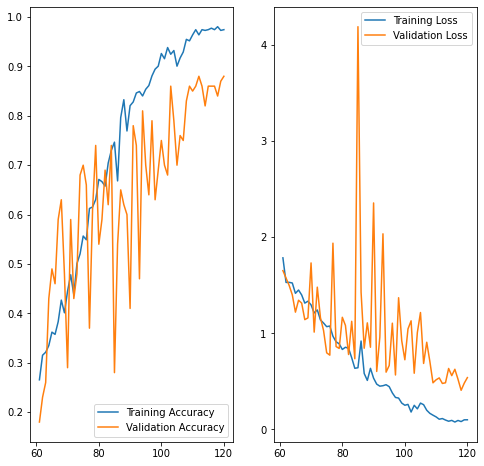

In [21]:
epochs= 60
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range= range(epochs+1, 2*epochs + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [22]:
model= load_model('model/model_init_2022-01-1201_59_34.391712/model-00060-0.10041-0.97436-0.53912-0.88000.h5')

history= model.fit_generator(train_generator, steps_per_epoch= steps_per_epoch, epochs= 30, verbose= 1, 
                    callbacks= callbacks_list, validation_data= val_generator, 
                    validation_steps= validation_steps, class_weight= None, workers= 1)

Epoch 1/30
11/11 [==============================] - 54s 5s/step - loss: 0.0856 - categorical_accuracy: 0.9744 - val_loss: 0.5302 - val_categorical_accuracy: 0.9000

Epoch 00001: saving model to model/model_init_2022-01-1201_59_34.391712/model-00001-0.08559-0.97436-0.53022-0.90000.h5
Epoch 2/30
11/11 [==============================] - 52s 5s/step - loss: 0.0864 - categorical_accuracy: 0.9759 - val_loss: 0.5181 - val_categorical_accuracy: 0.9000

Epoch 00002: saving model to model/model_init_2022-01-1201_59_34.391712/model-00002-0.08639-0.97587-0.51811-0.90000.h5
Epoch 3/30
11/11 [==============================] - 53s 5s/step - loss: 0.0739 - categorical_accuracy: 0.9744 - val_loss: 0.4287 - val_categorical_accuracy: 0.8800

Epoch 00003: saving model to model/model_init_2022-01-1201_59_34.391712/model-00003-0.07388-0.97436-0.42866-0.88000.h5
Epoch 4/30
11/11 [==============================] - 52s 5s/step - loss: 0.0608 - categorical_accuracy: 0.9879 - val_loss: 0.5311 - val_categorical_a

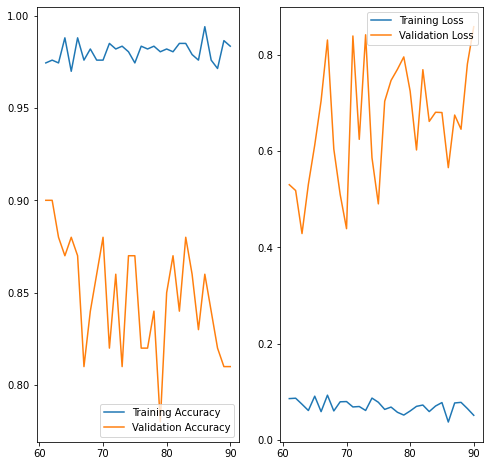

In [25]:
epochs= 30
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range= range(61, 91)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

- Total params: 2,817,477
- Trainable params: 2,816,997
- Non-trainable params: 480
- Best Epoch: 1st of second run (61th Epoch)
- **Training: loss: 0.0856, categorical_accuracy: 0.9744**
- **Validation: val_loss: 0.5302, val_categorical_accuracy: 0.9000**

We have got best model in 1st of second run (61th Epoch) (model-00001-0.08559-0.97436-0.53022-0.90000.h5).

### Model 9: Conv3D (Model 7 with RMSprop as optimizer)

In [ ]:
# Model function
def conv3D_model3(seq_shape, labels):
    model= Sequential()
    model.add(Conv3D(16, kernel_size= (3,3,3), input_shape= seq_shape, padding= 'same'))
    model.add(BatchNormalization(momentum= .9))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size= (2,2,2)))
    model.add(Conv3D(32, kernel_size= (3,3,3), padding= 'same'))
    model.add(BatchNormalization(momentum= .9))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size= (2,2,2)))
    model.add(Conv3D(64, kernel_size= (3,3,3), padding= 'same'))
    model.add(BatchNormalization(momentum= .9))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size= (2,2,2)))
    model.add(Conv3D(128, kernel_size= (3,3,3), padding= 'same'))
    model.add(BatchNormalization(momentum= .9))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size= (2,2,2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(512, activation= 'relu', kernel_initializer= 'he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation= 'relu', kernel_initializer= 'he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation= 'relu', kernel_initializer= 'he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(labels, activation= 'softmax'))
    model.compile(optimizer= 'rmsprop', loss= 'categorical_crossentropy', metrics= ['categorical_accuracy'])
    return model

In [ ]:
# Building model
seq_shape= (30,100,100,3)
labels= 5
conv3D_m3= conv3D_model3(seq_shape, labels)
conv3D_m3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 100, 100, 16)  1312      
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 100, 100, 16)  64        
_________________________________________________________________
activation_4 (Activation)    (None, 30, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 50, 50, 32)    13856     
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 50, 50, 32)    128       
_________________________________________________________________
activation_5 (Activation)    (None, 15, 50, 50, 32)   

In [ ]:
# Reducing batch size to 64 because of out of memory issue
batch_size= 64
train_generator, val_generator, steps_per_epoch, validation_steps= get_gen_steps(train_path, train_doc, val_path, val_doc, 
                                                                                 num_train_sequences, num_val_sequences, batch_size)

history= conv3D_m3.fit_generator(train_generator, steps_per_epoch= steps_per_epoch, epochs= 90, verbose= 1, 
                    callbacks= callbacks_list, validation_data= val_generator, 
                    validation_steps= validation_steps, class_weight= None, workers= 1, initial_epoch= 0)

Source path : data/Project_data/train ; batch size : 64
Epoch 1/90
11/11 [==============================] - 55s 5s/step - loss: 6.2547 - categorical_accuracy: 0.2247 - val_loss: 1.6139 - val_categorical_accuracy: 0.2600

Epoch 00001: saving model to model/model_init_2022-01-1201_59_34.391712/model-00001-6.25466-0.22474-1.61388-0.26000.h5
Epoch 2/90
11/11 [==============================] - 50s 5s/step - loss: 1.6921 - categorical_accuracy: 0.2262 - val_loss: 1.7637 - val_categorical_accuracy: 0.1300

Epoch 00002: saving model to model/model_init_2022-01-1201_59_34.391712/model-00002-1.69210-0.22624-1.76369-0.13000.h5
Epoch 3/90
11/11 [==============================] - 53s 5s/step - loss: 1.6115 - categorical_accuracy: 0.2971 - val_loss: 1.8979 - val_categorical_accuracy: 0.0800

Epoch 00003: saving model to model/model_init_2022-01-1201_59_34.391712/model-00003-1.61147-0.29713-1.89790-0.08000.h5
Epoch 4/90
11/11 [==============================] - 51s 5s/step - loss: 1.5634 - categorical


- Total params: 2,817,477
- Trainable params: 2,816,997
- Non-trainable params: 480
- Best Epoch: 45
- **Training: loss: 0.0491, categorical_accuracy: 0.9834**
- **Validation: val_loss: 0.4420, val_categorical_accuracy: 0.8800**

We have got best model in 45th epoch (model-00045-0.04912-0.98341-0.44200-0.88000.h5).

# Conclusion:
We have performed experiments with different types of architectures. For Conv2D+ RNN types of models, we have explored different transfer learnings and fine-tuned the pre-trained weights to extract features and then fed it to RNN-based networks like LSTM, RNN. This type of architectures have lot of model parameters and it took good amount of time to train these kinds of models. We explored 5 such models and got best validation accuracy of .85 using Xception(Finetuned) + LSTM architecture (Model 5). The model has 40133165 parameters.
Then we tried exploring different network architectures of Conv3D. Training time required for these models are far lesser than Conv2D+ RNN type models. Explored Adam, Nadam, RMSprop as optimizers in different experiments. Adam and Nadam gave faster convergence and better validation accuracy. We got best validation accuracy of .93 (Model 7). This model has only 2817477 parameters (almost 15 times lesser than best Conv2D+RNN type model). Model 7 (model-00025-0.17594-0.95023-0.28937-0.93000.h5) considered as our final model.
